In [1]:
import os
import pandas as pd
import numpy as np
import requests
import seaborn as sns

# Pandas section

Read in data as .csv from repo:

In [2]:
imdb_df = pd.read_csv('https://raw.githubusercontent.com/whsky/imdb_100/master/data/imdb_100.csv')

In [4]:
imdb_df.head()

,star_rating,title,year,content_rating,genre,duration,gross
0,9.3,The Shawshank Redemption,1994,R,Drama,142,1963330
1,9.2,The Godfather,1972,R,Crime,175,28341469
2,9.0,The Dark Knight,2008,PG-13,Action,152,1344258
3,9.0,The Godfather: Part II,1974,R,Crime,202,134966411
4,8.9,Pulp Fiction,1994,R,Crime,154,1935047


Get the shape of the DF - (rows, columns):

In [5]:
dims = imdb_df.shape
print('Rows: {}'.format(dims[0]))
print('Columns: {}'.format(dims[1]))

Rows: 100
Columns: 7


Get the column names:

In [7]:
print(imdb_df.columns.values)

['star_rating' 'title' 'year' 'content_rating' 'genre' 'duration' 'gross']


Get the distinct genre types:

In [8]:
print(imdb_df.genre.unique())

['Drama            ' 'Crime' 'Action' 'Biography' 'Adventure'
 'Western            ' 'Drama' 'Animation' 'Comedy' 'Horror' 'Mystery'
 'Comedy            ']


Hmmm...let's clean up genres -- some have trailing whitespace (e.g. 'Drama            '):

In [9]:
imdb_df['genre'] = [x.strip() for x in imdb_df['genre']]
print(imdb_df.genre.unique())

['Drama' 'Crime' 'Action' 'Biography' 'Adventure' 'Western' 'Animation'
 'Comedy' 'Horror' 'Mystery']


Much better! Now let's get the count as asked:

In [10]:
print('Number of genres: {}'.format(len(imdb_df.genre.unique())))

Number of genres: 10


Use 'groupby()' and 'count()' to get counts of titles by genre:

In [11]:
print(imdb_df[['title', 'genre']].groupby('genre').count())

           title
genre           
Action        17
Adventure      9
Animation     10
Biography      5
Comedy         7
Crime         20
Drama         25
Horror         2
Mystery        2
Western        3


# API section

Let's build some helper functions to assist with formatting and handling requests:

First, we need to reformat the text of the movie title so we can plug it into the API URL.
For example, we need **'The Shawshank Redemption'** to look like **'the+shawshank+redemption'**

In [13]:
def format_title(title):
    t = title.lower()
    t = t.split(' ')
    return '+'.join(t)

Now we can take that re-formatted title and generate the URL for the API request.

Notice we are using an environment variable to store our API key *(we don't want to publish that sucker for everyone to see on GitHub!)* so be sure to export this variable as **OMDB_KEY** in your bash profile or set it using a Jupyter magic %env call.

In [14]:
def get_url(title):
    key = os.environ['OMDB_KEY']
    title = format_title(title)
    api_url = 'http://www.omdbapi.com/?apikey={key}&t={t}'.format(
                key=key,
                t=title)
    return api_url


Next we can write a quick helper function for actually making the requests and returning the data as a JSON object:

In [15]:
def make_request(url):
    req = requests.get(url, timeout=5)
    data = req.json()
    return data

The JSON returned from the API call has much more info than we need right now, so we will just pull out the values of interest. Namely, the Rotten Tomatoes Score. We can do this by ccessing the key/value pairs needed just like you would with a *dict* type.

Also notice that we need to throw in some **if** statements to catch when we get some edge cases (for example, when the API fails to match the movie, or when there is no RT score for a movie).

In [16]:
def get_rt_score(json):
    # check that the API returned valid response
    if json['Response'] == 'True':
        # pull out list of ratings from JSON
        rating_list = json['Ratings']
        # check that RT is in the Ratings section:
        sources = [r['Source'] for r in rating_list]
        if 'Rotten Tomatoes' in sources:
            # loop through ratings to find RT
            for rating in rating_list:
                if rating['Source'] == 'Rotten Tomatoes':
                    rt = rating['Value']
                else:
                    continue
        # otherwise if RT not in ratings, then set to NULL
        else:
            rt = np.nan
    # if the API did not find a match, set rating to NULL
    else:
        rt = np.nan

    return rt

These Rotten Tomatoes Scores are returned as a string like '86%', so we can build a simple function to convert this to a decimal value.

But again, we have to watch for instances where the RT Score was returned as a NULL value, so we just some **if/else** logic:

In [17]:
def rt_to_dec(rt_score):
    if type(rt_score) in (str, unicode):
        # strip the percent sign from the string
        rt = rt_score.replace('%', '')
        # convert to decimal
        rt = int(rt)/100.
    else:
        rt = rt_score
    return rt

We can do the same formatting for the IMDB rating so we get '0.98' instead of '9.8':

In [18]:
def imdb_to_dec(imdb_rating):
    return imdb_rating/10.

Lastly we can build a function that gives us the Five Number Summary of a series of numbers. Because we will potentially have NULL values, we will need to use the **'nanpercentile()'** function from NumPy to get our quartle values:

In [19]:
def five_num_summ(series):
    min = series.min()
    q1, q2, q3 = np.nanpercentile(series, [25, 50, 75])
    max = series.max()
    return min, q1, q2, q3, max

Excellent!
Now with our helper functions in place, we can just iterate over our movie titles in our DataFrame to get the RT scores back from the API:

In [25]:
rt_score = []
for index, row in imdb_df.iterrows():
    url = get_url(row['title'])
    data = make_request(url)
    rt = get_rt_score(data)
    rt = rt_to_dec(rt)
    rt_score.append(rt)

imdb_df['rt_score'] = rt_score

KeyError: 'OMDB_KEY'

In case we got a **KeyError** thrown on that last cell, I have dumped the resulting values into a new .csv file in the repo so we can continue.

Let's read that in and we can proceed with out having to worry about API keys.

In [27]:
imdb_df = pd.read_csv('https://raw.githubusercontent.com/whsky/imdb_100/master/data/imdb_100_mod.csv')

Now we need to re-sort the DataFrame based on Rotten Tomatoes Scores and get the top five titles:

In [28]:
# sort the DF by RT scores
imdb_df.sort_values(by='rt_score', ascending=False, inplace=True)
# Top 5 by RT score
print(imdb_df.head(5)['title'])

0                  Seven Samurai
5                   Modern Times
8                    Rear Window
7    Witness for the Prosecution
6                   12 Angry Men
Name: title, dtype: object


Let's get the top 5 "R" rated movies:

In [30]:
print(imdb_df[imdb_df['content_rating']=='R'].head(5)[['title', 'content_rating', 'rt_score']])

                title content_rating  rt_score
1        Citizen Kane              R      1.00
2           Toy Story              R      1.00
10  L.A. Confidential              R      0.99
11        Taxi Driver              R      0.98
12        Toy Story 3              R      0.98


Looks like some movies are mis-rated **(e.g. Toy Story is not likely "R" rated)**

How about the average RT score:

In [31]:
avg_rt = imdb_df['rt_score'].mean()
print('Avg. Rotten Tomatoes Score: {}'.format(avg_rt))

Avg. Rotten Tomatoes Score: 0.9137234042553192


Now let's get the 5 number summary (min, 1st q, 2nd q, 3rd q, max):

In [33]:
min, q1, q2, q3, max = five_num_summ(imdb_df['rt_score'])
print('''min: {min}\n
1st Qrt: {q1}\n
2nd Qrt: {q2}\n
3rd Qrt: {q3}\n
max: {max}'''.format(
    min=min, q1=q1, q2=q2, q3=q3, max=max)
)

min: 0.72

1st Qrt: 0.88

2nd Qrt: 0.93

3rd Qrt: 0.97

max: 1.0


Now we can convert the IMDB rating to the same decimal scale as our RT Scores -- [0,1]:

In [35]:
star_dec = [imdb_to_dec(x) for x in imdb_df['star_rating']]
imdb_df['star_decimal'] = star_dec

And we can build the ratio of IMDB rating / RT Score:

In [36]:
ratio = imdb_df['star_decimal'] / imdb_df['rt_score']
imdb_df['ratio'] = ratio

Now we can get the titles with the largest and smallest ratios:

In [39]:
max_ratio = imdb_df['ratio'].max()
max_title = imdb_df[imdb_df['ratio'] == max_ratio]['title'].values[0]
print('Highest IMDB / RT ratio:\n {0} ({1})'.format(max_title, max_ratio))

min_ratio = imdb_df['ratio'].min()
min_title = imdb_df[imdb_df['ratio'] == min_ratio]['title'].values[0]
print('\nLowest IMDB / RT ratio:\n {0} ({1})'.format(min_title, min_ratio))

Highest IMDB / RT ratio:
 Forrest Gump (1.2222222222222223)

Lowest IMDB / RT ratio:
 Toy Story (0.8300000000000001)


# Plots

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

### Regression Plots to show relationship between two fields:

RT Score vs. IMDB Rating:

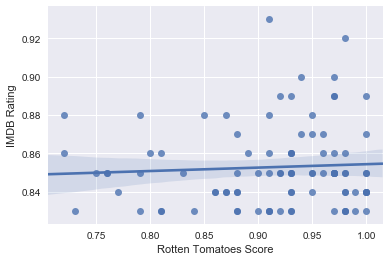

In [41]:
x = imdb_df['rt_score']
y = imdb_df['star_decimal']
sns.regplot(x=x, y=y)
plt.xlabel('Rotten Tomatoes Score')
plt.ylabel('IMDB Rating')
plt.show()

Duration vs IMDB Rating:

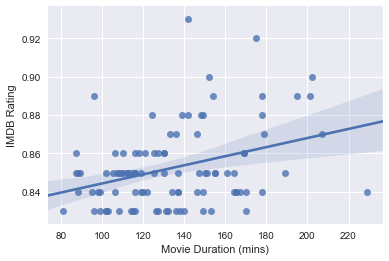

In [42]:
x = imdb_df['duration']
sns.regplot(x=x, y=y)
plt.xlabel('Movie Duration (mins)')
plt.ylabel('IMDB Rating')
plt.show()

Bar graph of title counts by genre:

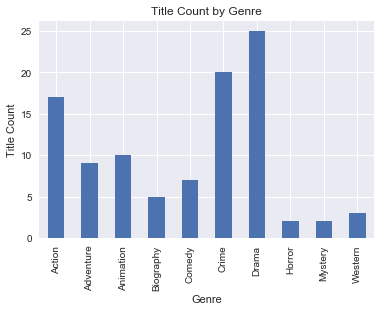

In [44]:
imdb_df[['title', 'genre']].groupby('genre').count().plot(
    kind='bar',
    title='Title Count by Genre',
    legend=False
    )
plt.xlabel('Genre')
plt.ylabel('Title Count')
plt.show()

Histogram of RT Scores:

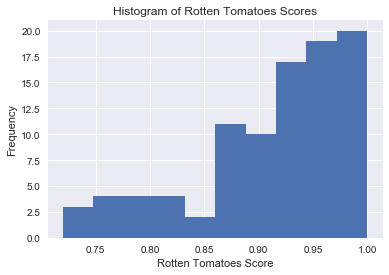

In [45]:
imdb_df['rt_score'].plot(
    kind='hist',
    title='Histogram of Rotten Tomatoes Scores'
    )
plt.xlabel('Rotten Tomatoes Score')
plt.show()

Lastly, let's take a look at how the ratings are distributed by release year. In other words, do we see a change in rating distributions over time?

In [51]:
print(imdb_df[['title', 'year']].groupby('year').count())

       title
year        
-2017      1
 1931      2
 1936      1
 1940      1
 1941      1
 1942      1
 1946      1
 1950      1
 1954      2
 1957      3
 1960      1
 1964      1
 1965      1
 1966      1
 1968      2
 1971      1
 1972      1
 1974      1
 1975      1
 1976      1
 1977      1
 1979      2
 1980      2
 1981      2
 1983      2
 1984      1
 1985      1
 1986      1
 1987      1
 1988      2
 1989      1
 1990      1
 1991      2
 1992      1
 1993      1
 1994      5
 1995      4
 1997      4
 1998      2
 1999      4
 2000      4
 2001      2
 2002      3
 2003      2
 2004      1
 2005      2
 2006      3
 2007      1
 2008      2
 2009      3
 2010      2
 2011      1
 2012      3
 2014      2
 2016      2
 2017      1
 2018      1


Hmmm...seems like some more data entry issues (the year '-2017')

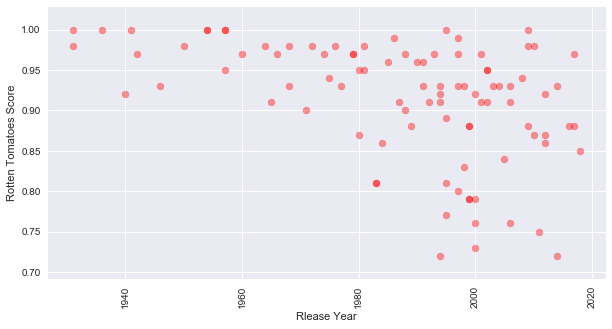

In [57]:
plt.rcParams['figure.figsize'] = [10, 5]

sub_df = imdb_df[['year', 'rt_score']].sort_values(by='year')
x = abs(sub_df['year'])
y = sub_df['rt_score']
plt.scatter(x=x, y=y, c='r', alpha=0.4)
plt.xlabel('Rlease Year')
plt.ylabel('Rotten Tomatoes Score')
plt.xticks(rotation=90)
plt.show()

We can see that the range of values tends to widen out as the movies get newer...this implies that there may be some dependency on rlease date to the RT Score.